In [74]:
import os

current_directory = os.getcwd()
relative_path = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent'

directory_path = os.path.join(current_directory, relative_path)

for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\accentDB_extended.tar.gz
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\files.tree
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\LICENSE
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\accentdb_core\data\american\speaker\american_data (1).wav
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\accentdb_core\data\american\speaker\american_data (10).wav
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\accentdb_core\data\american\speaker\american_data (100).wav
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\accentdb_core\data\american\speaker\american_data (101).wav
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\accentdb_core\data\american\speaker\american_data (102).wav
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent\accentdb_core\data\american\speaker\american_data (103).wav
E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

In [76]:
filename = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_extended/data/australian/speaker/australian_s01_(9).wav'

### Eksplorasi Data

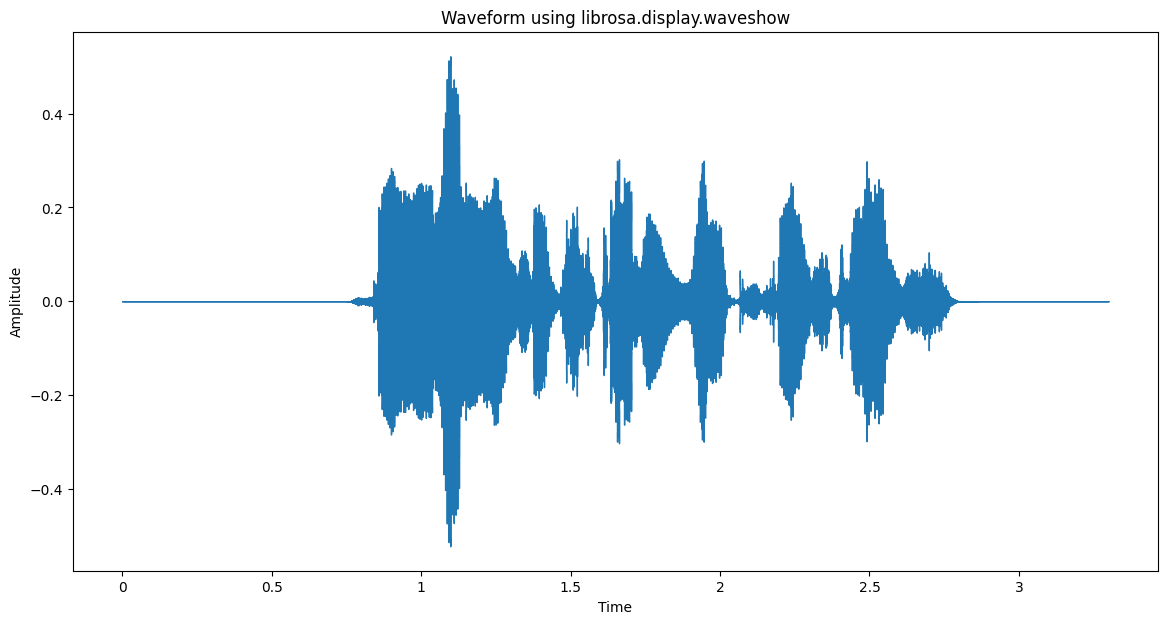

In [77]:
import IPython.display as ipd
import librosa 
import librosa.display

Librosa_data, Librosa_sample_rate = librosa.load(filename, sr=44100)
plt.figure(figsize=(14, 7))
librosa.display.waveshow(Librosa_data, sr=Librosa_sample_rate)
plt.title('Waveform using librosa.display.waveshow')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [78]:
ipd.Audio(Librosa_data, rate=Librosa_sample_rate)
print('Librosa sample rate = ', Librosa_sample_rate)
print('Mono Audio of Librosa_data:', Librosa_data)

Librosa sample rate =  44100
Mono Audio of Librosa_data: [0. 0. 0. ... 0. 0. 0.]


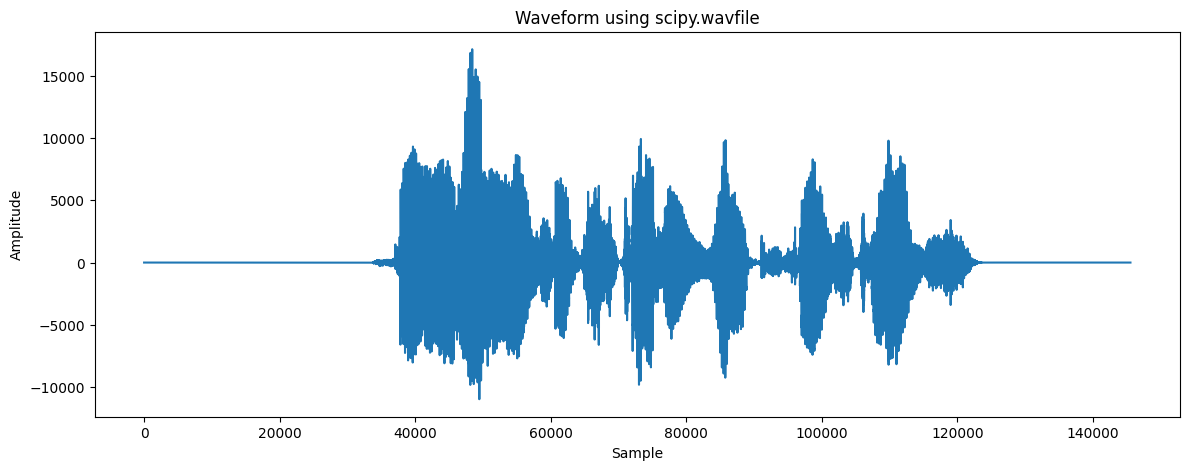

First 80000 sample values of the audio waveform:
[ 0.        0.        0.       ... 28.309376 48.00649  36.53318 ]


In [79]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(filename)

# Periksa dan konversi ke sample rate 44100 Hz
if wave_sample_rate != 44100:
    wave_audio = librosa.resample(wave_audio.astype(np.float32), orig_sr=wave_sample_rate, target_sr=44100)
    wave_sample_rate = 44100

plt.figure(figsize=(14, 5))
plt.plot(wave_audio)
plt.title('Waveform using scipy.wavfile')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

output_txt_file = 'waveform_values.txt'
np.savetxt(output_txt_file, wave_audio, fmt='%f')

print("First 80000 sample values of the audio waveform:")
print(wave_audio[:80000])

### DC-REMOVAL

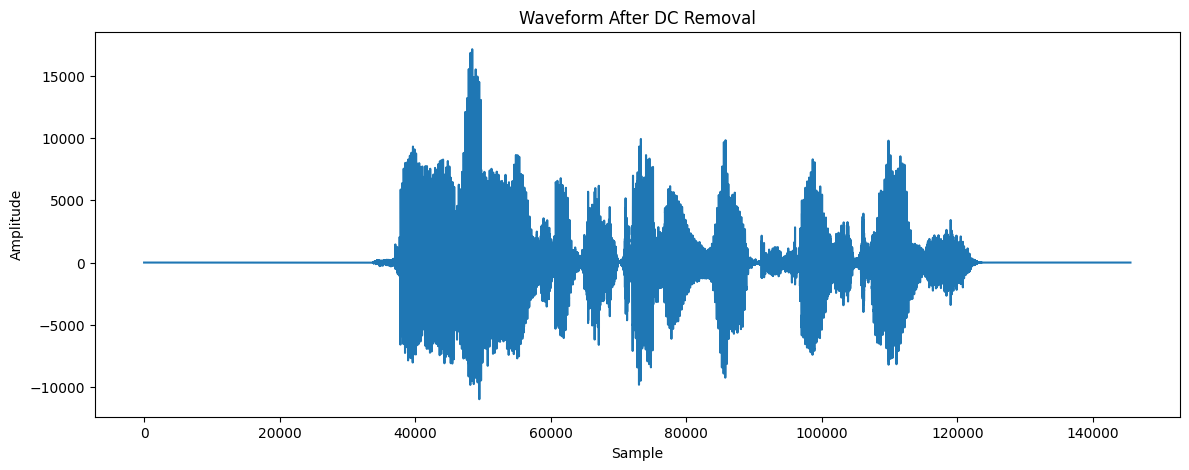

First 80,000 sample values of the audio waveform after DC removal:
[ 1.6529928  1.6529928  1.6529928 ... 29.962368  49.65948   38.186172 ]


In [84]:
# Remove DC component by subtracting the mean
dc_offset = np.mean(wave_audio)
wave_audio_dc_removed = wave_audio - dc_offset

# Plot the waveform after DC removal
plt.figure(figsize=(14, 5))
plt.plot(wave_audio_dc_removed)
plt.title('Waveform After DC Removal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

output_txt_file = 'DC-removal_values.txt'
np.savetxt(output_txt_file, wave_audio_dc_removed, fmt='%f')

# Print the first 80,000 sample values of the waveform after DC removal
print("First 80,000 sample values of the audio waveform after DC removal:")
print(wave_audio_dc_removed[:80000])

### PROSES PRE-EMPHASIS

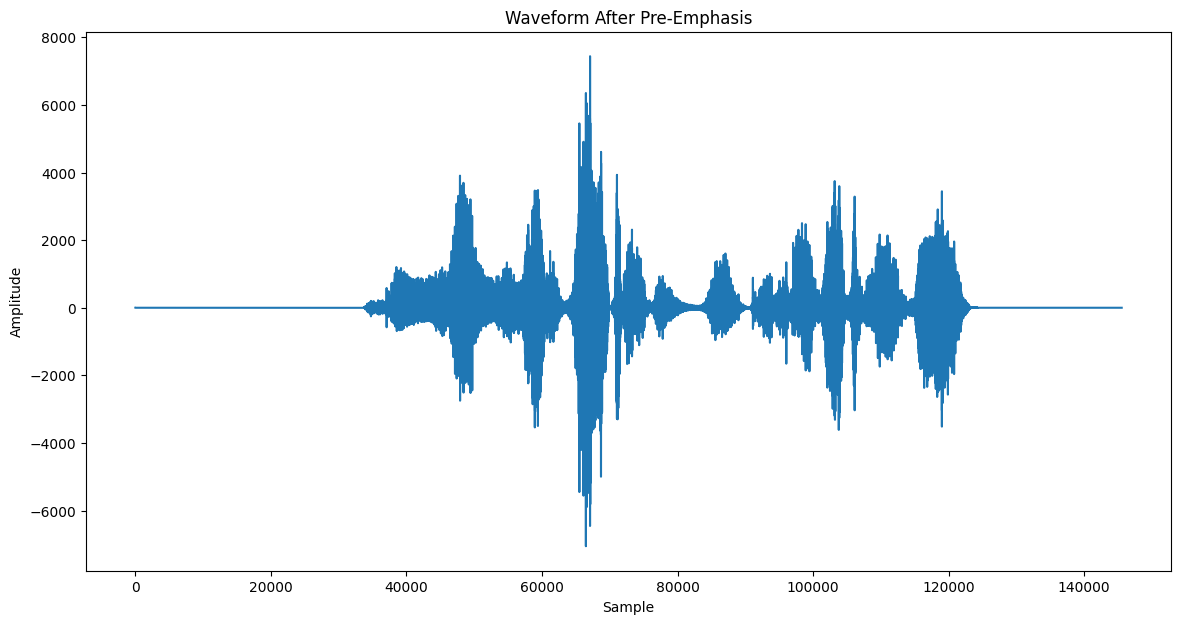

First 80,000 sample values of the audio waveform after pre-emphasis:
[  1.6529928    0.04958975   0.04958975 ... -25.956917    20.595984
  -9.983524  ]


In [85]:
pre_emphasis_coeff = 0.97

# Apply pre-emphasis filter
wave_audio_pre_emphasized = np.append(wave_audio_dc_removed[0], wave_audio_dc_removed[1:] - pre_emphasis_coeff * wave_audio_dc_removed[:-1])

# Plot the waveform after pre-emphasis
plt.figure(figsize=(14, 7))
plt.plot(wave_audio_pre_emphasized)
plt.title('Waveform After Pre-Emphasis')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

output_txt_file = 'Pre-emphasis_values.txt'
np.savetxt(output_txt_file, wave_audio_pre_emphasized, fmt='%f')

# Print the first 80,000 sample values of the waveform after pre-emphasis
print("First 80,000 sample values of the audio waveform after pre-emphasis:")
print(wave_audio_pre_emphasized[:80000])

### FRAME BLOCKING

In [86]:
frame_size = 2205  # Number of samples per frame
hop_size = 512     # Number of samples between frames

# Function to create frames
def frame_signal(signal, frame_size, hop_size):
    # Print signal length
    print("Signal Length:", len(signal))
    
    num_frames = int(np.ceil((len(signal) - frame_size) / hop_size) + 1)
    frames = np.zeros((num_frames, frame_size))
    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        frames[i, :min(frame_size, len(signal) - start)] = signal[start:end]
    return frames, num_frames

# Apply framing
frames, num_frames = frame_signal(wave_audio_pre_emphasized, frame_size, hop_size)

# Print the number of frames
print("Number of frames:", num_frames)

Signal Length: 145530
Number of frames: 281


### WINDOWING

In [107]:
def window_function(size):
    return np.hamming(size)

# Durasi jendela dalam detik
duration = 0.025
# Sampling rate dalam Hz
sample_rate = 176400
# Menghitung ukuran jendela dalam sampel
size = int(duration * sample_rate)

# Membuat jendela Hamming
hamming_window = window_function(size)

# Mencetak ukuran jendela
print(f"Ukuran jendela Hamming: {size} sampel")

# Mencetak nilai jendela Hamming
print("Nilai jendela Hamming:")
print(hamming_window)

output_txt_file = 'Hamming_window_values.txt'
np.savetxt(output_txt_file, hamming_window, fmt='%f')

# Function to create frames with windowing
def frame_signal(signal, frame_size, hop_size):
    num_frames = int(np.ceil((len(signal) - frame_size) / hop_size) + 1)
    frames = np.zeros((num_frames, frame_size))
    window = window_function(frame_size)
    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        frames[i, :min(frame_size, len(signal) - start)] = signal[start:end]
        frames[i] *= window  # Apply window function
    return frames

# Plot the first few windowed frames
plt.figure(figsize=(14, 7))
for i in range(min(num_frames, frames.shape[0])):  # Plot up to 5 frames
    plt.plot(frames[i], label=f'Frame {i+1}')
plt.title('Windowed Frames of the Audio Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the first few frames after windowing
print("First few frames after windowing:")
for i in range(min(10, frames.shape[0])):  # Print up to 5 frames
    print(f"Frame {i+1} (Windowed):")
    print(frames[i])
    print()
    
for i in range(frames.shape[0]):
    frame_file = f'frame_{i+1}.txt'
    np.savetxt(frame_file, frames[i], fmt='%f')
    print(f"Frame {i+1} telah disimpan ke '{frame_file}'.")

TypeError: 'numpy.ndarray' object is not callable

<Figure size 1400x700 with 0 Axes>

### PROSES FFT

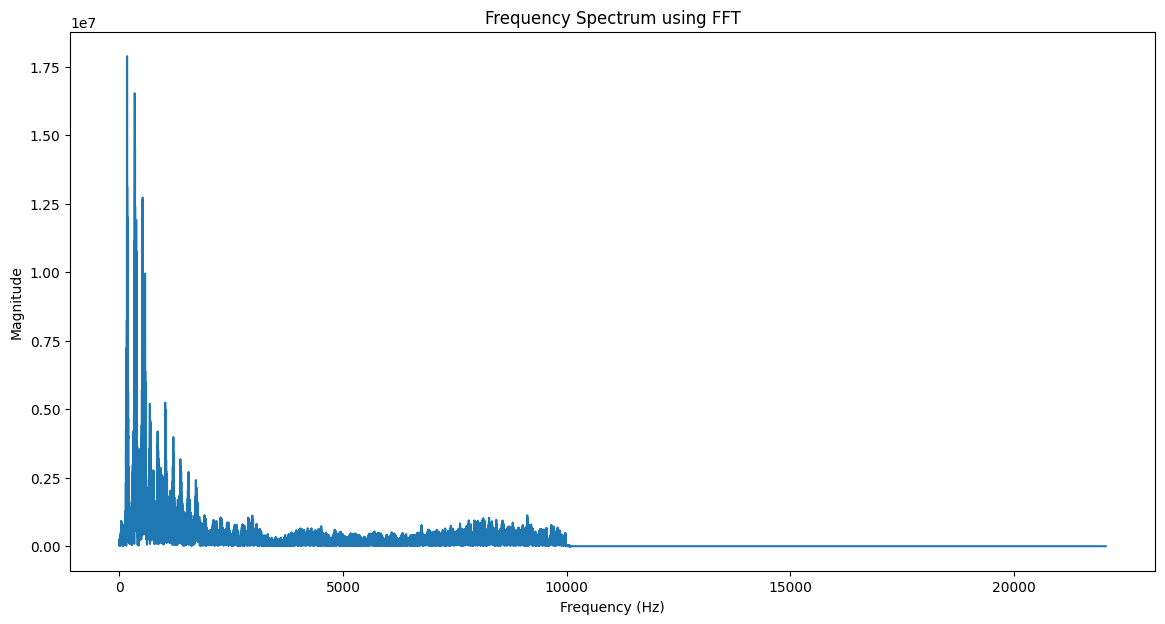

Frequency: 0.00 Hz, Magnitude: 240560.02
Frequency: 0.30 Hz, Magnitude: 180983.78
Frequency: 0.61 Hz, Magnitude: 99292.02
Frequency: 0.91 Hz, Magnitude: 93946.96
Frequency: 1.21 Hz, Magnitude: 92459.17
Frequency: 1.52 Hz, Magnitude: 65576.78
Frequency: 1.82 Hz, Magnitude: 120784.26
Frequency: 2.12 Hz, Magnitude: 109386.08
Frequency: 2.42 Hz, Magnitude: 55131.11
Frequency: 2.73 Hz, Magnitude: 14566.19
Frequency: 3.03 Hz, Magnitude: 130932.91
Frequency: 3.33 Hz, Magnitude: 187774.05
Frequency: 3.64 Hz, Magnitude: 107182.07
Frequency: 3.94 Hz, Magnitude: 112239.68
Frequency: 4.24 Hz, Magnitude: 107306.39
Frequency: 4.55 Hz, Magnitude: 203834.41
Frequency: 4.85 Hz, Magnitude: 48132.25
Frequency: 5.15 Hz, Magnitude: 179172.27
Frequency: 5.45 Hz, Magnitude: 144340.37
Frequency: 5.76 Hz, Magnitude: 218913.79
Frequency: 6.06 Hz, Magnitude: 193843.79
Frequency: 6.36 Hz, Magnitude: 51253.20
Frequency: 6.67 Hz, Magnitude: 41434.26
Frequency: 6.97 Hz, Magnitude: 99012.64
Frequency: 7.27 Hz, Magnit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import dct

# Membaca file audio
wave_sample_rate, wave_audio = wav.read(filename)

# Periksa dan konversi ke sample rate 44100 Hz
if wave_sample_rate != 44100:
    wave_audio = librosa.resample(wave_audio.astype(np.float32), orig_sr=wave_sample_rate, target_sr=44100)
    wave_sample_rate = 44100

# Hitung FFT dari sinyal audio
n_fft = len(wave_audio)  # Jumlah sampel
audio_fft = np.fft.fft(wave_audio)
frequencies = np.fft.fftfreq(n_fft, 1 / wave_sample_rate)

# Hanya ambil nilai positif dari frekuensi dan FFT
positive_frequencies = frequencies[:n_fft // 2]
magnitude = np.abs(audio_fft)[:n_fft // 2]

# Plot tabel frekuensi
plt.figure(figsize=(14, 7))
plt.plot(positive_frequencies, magnitude)
plt.title('Frequency Spectrum using FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

#hasil untuk nilai FFT
for freq, mag in zip(positive_frequencies, magnitude):
    print(f"Frequency: {freq:.2f} Hz, Magnitude: {mag:.2f}")



### MEL SPECTOGRAM DAN MEL FILTER BANK

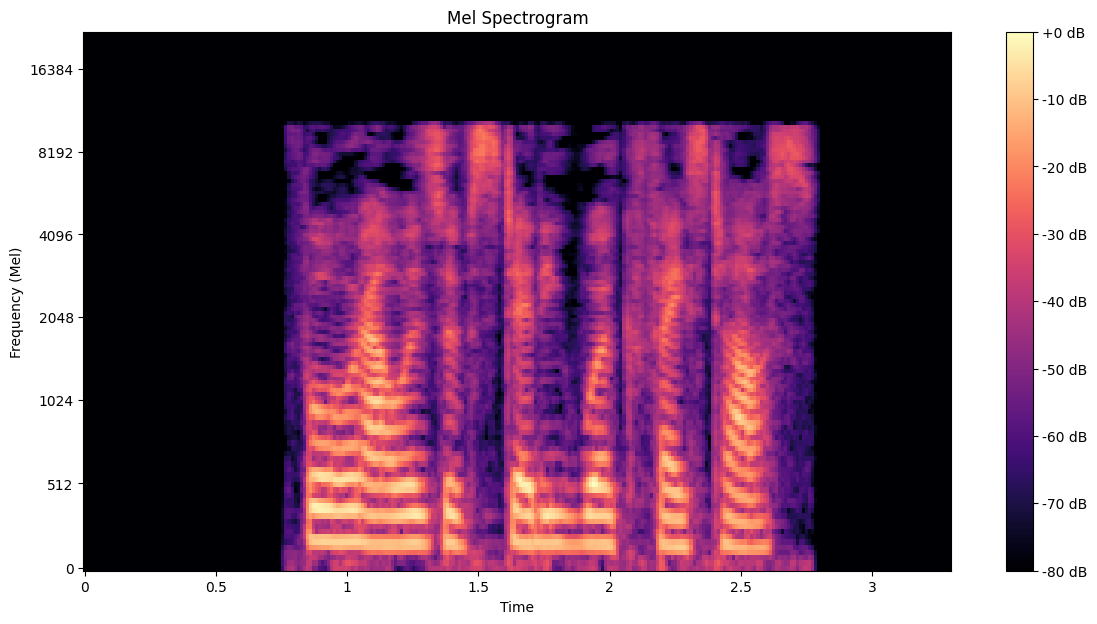

Mel Spectrogram (dB):
 [[-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 ...
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]]


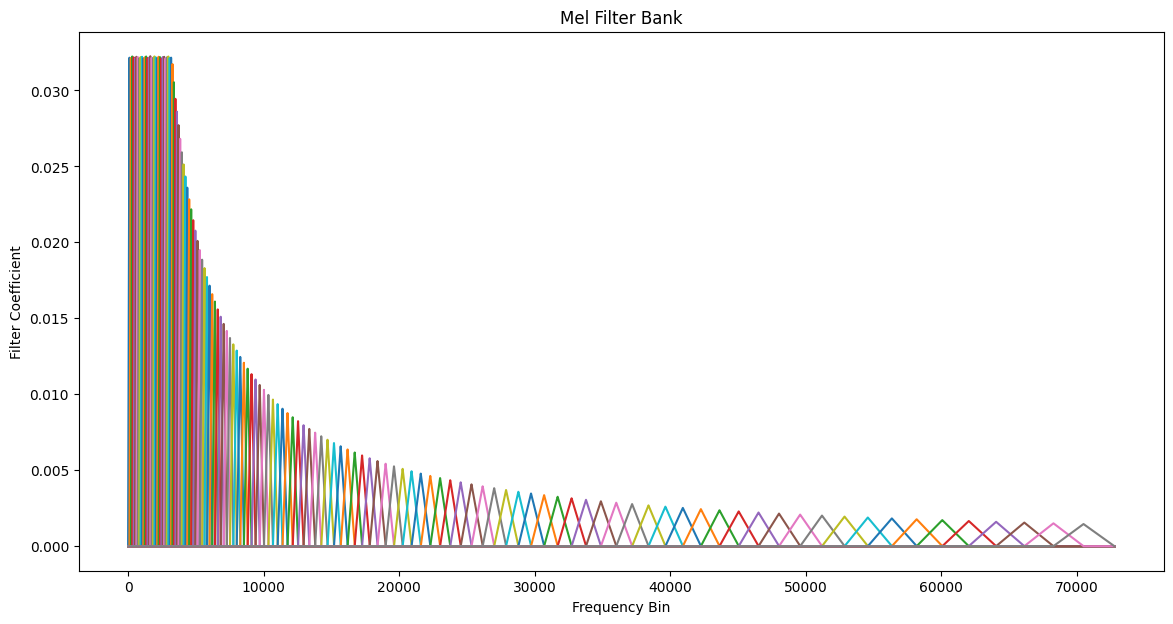

Mel Filter Bank:
 [[-0.0000000e+00  3.1524952e-04  6.3049904e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.2789492e-06
   6.3947459e-07  1.5354208e-17]]


In [ ]:
# Konversi ke floating point dan normalisasi jika perlu
wave_audio = wave_audio.astype(np.float32)

# Jika data integer, normalisasikan ke rentang -1.0 hingga 1.0
if wave_audio.dtype == np.int16:
    wave_audio /= np.iinfo(np.int16).max
elif wave_audio.dtype == np.int32:
    wave_audio /= np.iinfo(np.int32).max

# Compute the Short-Time Fourier Transform (STFT)
stft = np.abs(librosa.stft(wave_audio))

# Compute the Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(S=stft**2, sr=44100, n_mels=128)

# Convert to log scale (dB)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display the Mel Spectrogram
plt.figure(figsize=(14, 7))
librosa.display.specshow(mel_spectrogram_db, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency (Mel)')
plt.show()

# Cetak hasil Mel Spectrogram
print("Mel Spectrogram (dB):\n", mel_spectrogram_db)

# Compute Mel filter bank
mel_filters = librosa.filters.mel(sr=44100, n_fft=len(wave_audio), n_mels=128)

# Plot Mel filter bank
plt.figure(figsize=(14, 7))
plt.plot(mel_filters.T)
plt.title('Mel Filter Bank')
plt.xlabel('Frequency Bin')
plt.ylabel('Filter Coefficient')
plt.show()

# Cetak hasil Mel Filter Bank
print("Mel Filter Bank:\n", mel_filters)


Applying DCT...
DCT output shape: (128, 285)
DCT values (first 100 frames):
 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.0821263e+10
   2.0264931e+10  1.7167410e+10]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.2350142e+10
   2.3168944e+10  2.0921786e+10]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  7.4118277e+09
   1.0588041e+10  1.2778738e+10]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.1823258e+08
   4.1758346e+08  1.3717258e+09]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.9148396e+09
  -4.7913830e+08  1.4601810e+09]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.8533350e+09
  -6.3679898e+08  9.4942310e+08]]


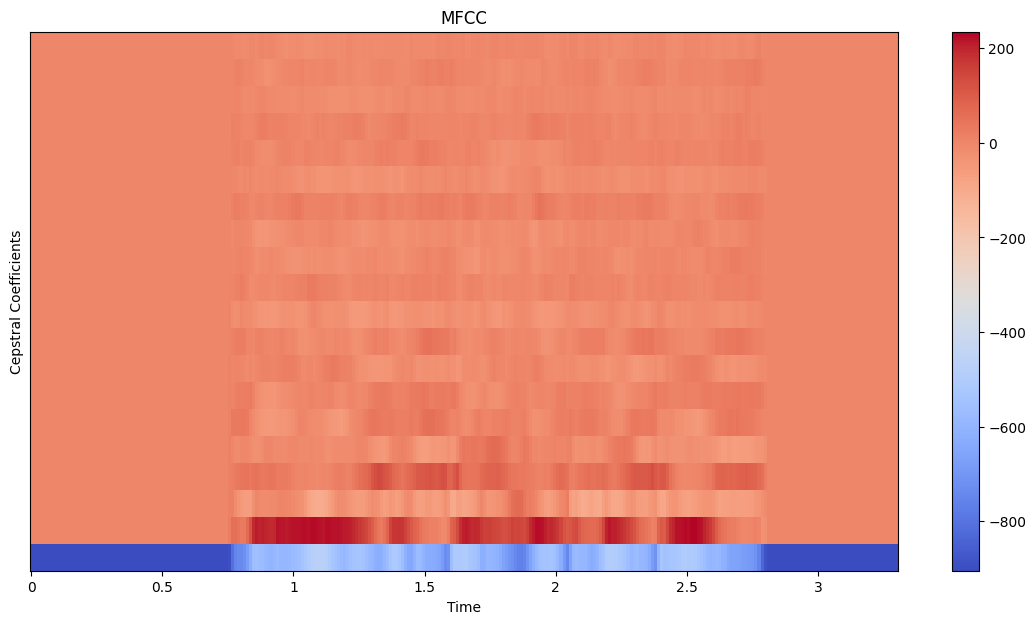

MFCC:
 [[-905.0967 -905.0967 -905.0967 ... -905.0967 -905.0967 -905.0967]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 ...
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]]

Mean of MFCC Coefficients:
[-7.1459564e+02  8.4190659e+01 -2.6874123e+01  3.4341446e+01
 -6.5903850e+00  3.4759295e+00  5.1598372e+00 -5.9271178e+00
  3.9605203e+00 -1.4595727e+01  3.1446421e+00 -4.5182018e+00
 -7.0690351e+00  8.3832293e+00 -9.9724894e+00  2.2746844e+00
  4.1743045e+00 -4.8723469e+00  2.9636079e-01 -3.9772160e+00]


In [ ]:
# Compute MFCC using DCT
def compute_mfcc(mel_spectrogram, num_ceps=20):
    """
    Compute MFCC from Mel-Spectrogram using DCT.
    
    Parameters:
        mel_spectrogram (np.ndarray): 2D array with shape (num_mel_bins, num_frames).
        num_ceps (int): Number of cepstral coefficients to return.
    
    Returns:
        np.ndarray: 2D array with shape (num_ceps, num_frames) of MFCCs.
    """
    # Apply DCT to the Mel-Spectrogram
    mfcc = dct(mel_spectrogram, type=2, axis=0, norm='ortho')
    
    # Keep only the first `num_ceps` coefficients
    mfcc = mfcc[:num_ceps]
    
    return mfcc

# Apply DCT to the Mel-Spectrogram
print("Applying DCT...")
mfcc = dct(mel_spectrogram, type=2, axis=0, norm='ortho')
    
# Print the shape of the DCT output
print("DCT output shape:", mfcc.shape)
    
# Print a snippet of the DCT values for inspection
print("DCT values (first 100 frames):\n", mfcc[:, :100])

# Compute MFCC from Mel Spectrogram
mfcc = compute_mfcc(mel_spectrogram_db)

# Display the MFCC
plt.figure(figsize=(14, 7))
librosa.display.specshow(mfcc, sr=44100, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('Cepstral Coefficients')
plt.show()

# Print the MFCC
print("MFCC:\n", mfcc)

mfcc_mean = np.mean(mfcc, axis=1)
print("\nMean of MFCC Coefficients:")
print(mfcc_mean)

#### Mengekstrak semua MFCCS data audio

In [ ]:
import numpy as np
import librosa

def extract_mfcc(file_path, n_mfcc=20, max_pad_len=156):
    y, sr = librosa.load(file_path, sr=44100)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = sum(true_label == predicted_label for true_label, predicted_label in zip(true_labels, predicted_labels))
    accuracy = (correct_predictions / len(true_labels)) * 100
    return accuracy


In [ ]:
import os

DIR1 = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_extended/data'

def count_files(directory):
    try:
        return len(os.listdir(directory))
    except FileNotFoundError:
        return 0
    
print(f"Di {DIR1}:")
for class_folder in os.listdir(DIR1):
    class_folder_path = os.path.join(DIR1, class_folder)
    if os.path.isdir(class_folder_path):
        print(f"Kelas folder: {class_folder}")
        for speaker_folder in os.listdir(class_folder_path):
            speaker_folder_path = os.path.join(class_folder_path, speaker_folder)
            if os.path.isdir(speaker_folder_path):
                num_files = count_files(speaker_folder_path)
                print(f"  - {speaker_folder}: {num_files} file(s)")


Di E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_extended/data:
Kelas folder: american
  - speaker: 100 file(s)
Kelas folder: australian
  - speaker: 100 file(s)
Kelas folder: bangla
  - speaker: 100 file(s)
Kelas folder: british
  - speaker: 100 file(s)
Kelas folder: indian
  - speaker: 100 file(s)
Kelas folder: malayalam
  - speaker: 100 file(s)
Kelas folder: odiya
  - speaker: 100 file(s)
Kelas folder: telugu
  - speaker: 100 file(s)
Kelas folder: welsh
  - speaker: 100 file(s)


In [ ]:
def feature_extract():
    DIR1 = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_extended/data'
    # DIR2 = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_core/data'
    dir_name = os.listdir(DIR1)
    # dir2_name = os.listdir(DIR2)
    speaker_files = []
    for folder_name in dir_name:
        for speaker in os.listdir(os.path.join(DIR1,folder_name)):
            for audio in os.listdir(os.path.join(DIR1,folder_name,speaker)):
                filename_speaker = os.path.join(DIR1,folder_name,speaker,audio)
                speaker_files.append([folder_name, filename_speaker])         
    # for folder2_name in dir2_name:
    #     for speaker2 in os.listdir(os.path.join(DIR2,folder2_name)):
    #         for audio2 in os.listdir(os.path.join(DIR2,folder2_name,speaker2)):
    #             filename2_speaker = os.path.join(DIR2,folder2_name,speaker2,audio2)
    #             speaker_files.append([folder2_name, filename2_speaker])
        
    return speaker_files

In [ ]:
f = feature_extract()
print(f[0])

['american', 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_extended/data\\american\\speaker\\american_s02_(1).wav']


In [ ]:
audio_data = pd.DataFrame(f, columns = ['Speaker','audio_path'])
print(audio_data.head())
print(audio_data.shape)
print(audio_data['Speaker'].unique())

    Speaker                                         audio_path
0  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
1  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
2  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
3  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
4  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
(900, 2)
['american' 'australian' 'bangla' 'british' 'indian' 'malayalam' 'odiya'
 'telugu' 'welsh']


In [ ]:
%%time

data_extracted = []
for file_path, audio_name in zip(audio_data['audio_path'], audio_data['Speaker']):
    mfccs = extract_mfcc(file_path)
    if mfccs is not None:
        data_extracted.append([mfccs, audio_name])

KeyboardInterrupt: 

In [ ]:
# import os
# import shutil
# import random
# # from collections import defaultdict

# def split_and_save_files(speaker_files, train_dir, val_dir, test_dir, train_pct, val_pct):
#     # Membuat folder jika belum ada
#     def create_dir_if_not_exists(directory):
#         if not os.path.exists(directory):
#             os.makedirs(directory)
    
#     create_dir_if_not_exists(train_dir)
#     create_dir_if_not_exists(val_dir)
#     create_dir_if_not_exists(test_dir)
    
#     # Membagi data
#     random.shuffle(speaker_files)  # Mengacak file
    
#     num_files = len(speaker_files)
#     num_train = int(num_files * train_pct)
#     num_val = int(num_files * val_pct)
    
#     train_files = speaker_files[:num_train]
#     val_files = speaker_files[num_train:num_train + num_val]
#     test_files = speaker_files[num_train + num_val:]

    
#     # Menyimpan file ke folder yang sesuai
#     def save_files(file_list, target_dir):
#         for folder_name, file_path in file_list:
#             dest_folder = os.path.join(target_dir, folder_name)
#             create_dir_if_not_exists(dest_folder)
#             shutil.copy(file_path, os.path.join(dest_folder, os.path.basename(file_path)))
    
#     save_files(train_files, train_dir)
#     save_files(val_files, val_dir)
#     save_files(test_files, test_dir)
    
#     # Menampilkan informasi file
#     print("Jumlah file di training set:", len(train_files))
#     print("Jumlah file di validation set:", len(val_files))
#     print("Jumlah file di test set:", len(test_files))

#     # Untuk menampilkan detail file jika diperlukan
#     print("\nTraining files:")
#     for folder_name, file_path in train_files:
#         print(f"Class: {folder_name}, File: {file_path}")
    
#     print("\nValidation files:")
#     for folder_name, file_path in val_files:
#         print(f"Class: {folder_name}, File: {file_path}")
    
#     print("\nTest files:")
#     for folder_name, file_path in test_files:
#         print(f"Class: {folder_name}, File: {file_path}")

# # Konfigurasi direktori dan persentase
# TRAIN_DIR = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/train'
# VALIDATION_DIR = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/validation'
# TEST_DIR = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/test'

# TRAIN_PERCENTAGE = 0.7
# VALIDATION_PERCENTAGE = 0.2
# TEST_PERCENTAGE = 0.1

# # Menjalankan fungsi
# speaker_files = feature_extract()
# split_and_save_files(speaker_files, TRAIN_DIR, VALIDATION_DIR, TEST_DIR, TRAIN_PERCENTAGE, VALIDATION_PERCENTAGE)

In [ ]:
X = [np.mean(i.T, axis=0) for i, _ in data_extracted]
X = np.asarray(X)
print(X.shape)

(900, 20)


In [ ]:
n_mfcc = 20
n_frames = X.shape[1] // n_mfcc
print("Calculated n_frames:", n_frames)


Calculated n_frames: 1


In [ ]:
X_4D = X.reshape((X.shape[0], n_mfcc, n_frames, 1))
print("Reshaped X shape:", X_4D.shape)


Reshaped X shape: (900, 20, 1, 1)


In [ ]:
import pandas as pd

y = np.array(pd.get_dummies([audio_name for _, audio_name in data_extracted]))
print("Original y shape:", y.shape)


Original y shape: (900, 9)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

num_samples = X_4D.shape[0]
X_2D = X_4D.reshape(num_samples, -1)

scaler = StandardScaler().fit(X_2D)
X_scaled_2D = scaler.transform(X_2D)

X_scaled_4D = X_scaled_2D.reshape(num_samples, n_mfcc, n_frames, 1)
print("Scaled and reshaped X shape:", X_scaled_4D.shape)

X_train, X_rem, y_train, y_rem = train_test_split(X_scaled_4D, y, test_size=0.3, random_state=10)
print('Train set:', X_train.shape, y_train.shape)
# print('Test set:', X_rem.shape, y_rem.shape)

Scaled and reshaped X shape: (900, 20, 1, 1)
Train set: (630, 20, 1, 1) (630, 9)


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=1/3, random_state=10)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

Validation set: (180, 20, 1, 1) (180, 9)
Test set: (90, 20, 1, 1) (90, 9)


In [ ]:
save_dir = 'data/'

# Buat direktori jika belum ada
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Menyimpan data ke file .npy di dalam direktori yang ditentukan
np.save(os.path.join(save_dir, 'X_train.npy'), X_train)
np.save(os.path.join(save_dir, 'y_train.npy'), y_train)
np.save(os.path.join(save_dir, 'X_val.npy'), X_val)
np.save(os.path.join(save_dir, 'y_val.npy'), y_val)
np.save(os.path.join(save_dir, 'X_test.npy'), X_test)
np.save(os.path.join(save_dir, 'y_test.npy'), y_test)

print("Data berhasil disimpan ke direktori:", save_dir)
print("X_train.npy")
print("y_train.npy")
print("X_val.npy")
print("y_val.npy")
print("X_test.npy")
print("y_test.npy")

Data berhasil disimpan ke direktori: data/
X_train.npy
y_train.npy
X_val.npy
y_val.npy
X_test.npy
y_test.npy


## Membuat Model

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D,  Flatten, Dense

In [ ]:
### No of classes
num_labels=y.shape[1]

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=X_train.shape[1:], padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

num_classes = y.shape[1]  # Ensure this matches the number of classes
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 20, 1, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 10, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 10, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 10, 1, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 5, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 3, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,289 (411.29 KB)

 Trainable params: 105,289 (411.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'])

### Epoch

In [ ]:
from datetime import datetime

# Menghapus ModelCheckpoint dan EarlyStopping
# (jika sebelumnya sudah didefinisikan, Anda bisa menghapus definisinya)

num_epochs = 5
num_batch_size = 32

start = datetime.now()

# Pelatihan model tanpa callbacks
history = model.fit(X_train, 
                    y_train, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_val, y_val),
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/5


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2199 - loss: 2.1037 - val_accuracy: 0.5389 - val_loss: 1.6424
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5820 - loss: 1.4440 - val_accuracy: 0.7889 - val_loss: 0.8812
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7780 - loss: 0.8134 - val_accuracy: 0.8889 - val_loss: 0.4202
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8565 - loss: 0.5137 - val_accuracy: 0.8944 - val_loss: 0.3259
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8872 - loss: 0.3806 - val_accuracy: 0.9111 - val_loss: 0.2475
Training completed in time:  0:00:04.800733


In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from datetime import datetime

# checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.keras', 
#                                verbose=1, 
#                                save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', 
#                                patience=1000,  # Adjust as needed
#                                verbose=1, 
#                                restore_best_weights=True)

# num_epochs = 5
# num_batch_size = 8

# start = datetime.now()

# history = model.fit(X_train, 
#                     y_train, 
#                     batch_size=num_batch_size, 
#                     epochs=num_epochs, 
#                     validation_data=(X_test, y_test), 
#                     callbacks=[checkpointer, early_stopping], 
#                     verbose=1)

# duration = datetime.now() - start
# print("Training completed in time: ", duration)


### Evaluasi Akurasi pada Data Testing

In [ ]:
results = model.evaluate(X_test, y_test)

test_loss = results[0]
test_accuracy = results[1]

print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9510 - loss: 0.2456 
Test Loss: 0.2647
Test Accuracy: 93.33%


In [ ]:
# Prediksi pada data uji (Opsional)
predictions = model.predict(X_test)

# Contoh: Menampilkan beberapa prediksi pertama
for i in range(5):
    print(f"True Label: {y_test[i]}, Predicted Label: {predictions[i].argmax()}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
True Label: [False  True False False False False False False False], Predicted Label: 1
True Label: [False  True False False False False False False False], Predicted Label: 1
True Label: [False False False False  True False False False False], Predicted Label: 4
True Label: [False False False False False  True False False False], Predicted Label: 5
True Label: [False False False False False False  True False False], Predicted Label: 6


### METRIKS EVALUASI

In [ ]:
from sklearn.metrics import classification_report


class_labels = ['American', 'Australian', 'Bangla (Western India)', 'British', 'Indian', 'Malayam (South Indian)', 'Odiya (Eastern Indian)', 'Telugu (South-east Indian)', 'Welsh']

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4)
print(report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
                            precision    recall  f1-score   support

                  American     1.0000    1.0000    1.0000        10
                Australian     1.0000    1.0000    1.0000        17
    Bangla (Western India)     1.0000    0.7692    0.8696        13
                   British     1.0000    0.8571    0.9231         7
                    Indian     0.9000    1.0000    0.9474         9
    Malayam (South Indian)     0.7000    0.8750    0.7778         8
    Odiya (Eastern Indian)     0.7778    1.0000    0.8750         7
Telugu (South-east Indian)     1.0000    0.9167    0.9565        12
                     Welsh     1.0000    1.0000    1.0000         7

                  accuracy                         0.9333        90
                 macro avg     0.9309    0.9353    0.9277        90
              weighted avg     0.9460    0.9333    0.9346        90



## Plot Accuracy dan Model Loss Training dan Validasi

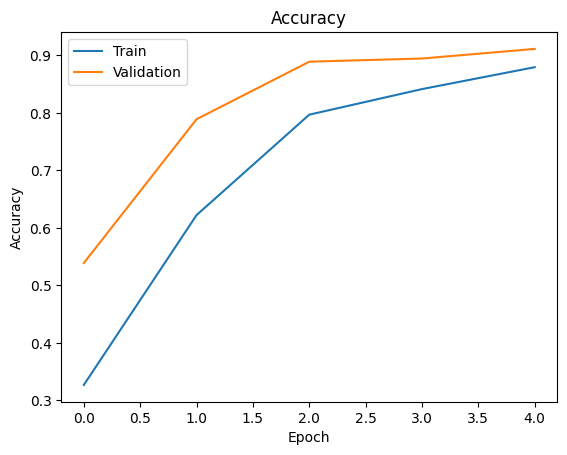

Training Accuracy: 87.94%
Validation Accuracy: 91.11%


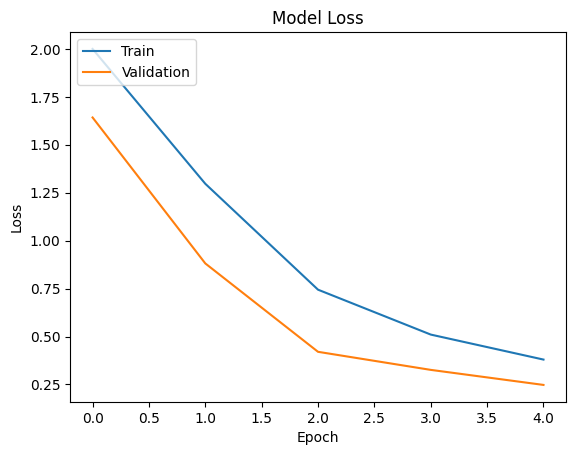

Final Training Loss: 0.3797
Final Validation Loss: 0.2475


In [ ]:
# Plot training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()
print("Training Accuracy: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Validation Accuracy: {:.2f}%".format(history.history['val_accuracy'][-1] * 100))
# print("Test Accuracy: {:.2f}%".format(history.history['val_accuracy'][-1] * 100))

# Plot training and validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation','Test'], loc = 'upper left')
plt.show()

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Final Training Loss: {:.4f}".format(train_loss))
print("Final Validation Loss: {:.4f}".format(val_loss))
# print("Final Test Loss: {:.4f}".format(val_loss))

### Confusion Matrix 

In [ ]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

test_accuracy_percent = calculate_accuracy(true_labels, predicted_labels)
print("Test Accuracy (percentage): {:.2f}%".format(test_accuracy_percent))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy (percentage): 93.33%


Text(95.7222222222222, 0.5, 'True_value')

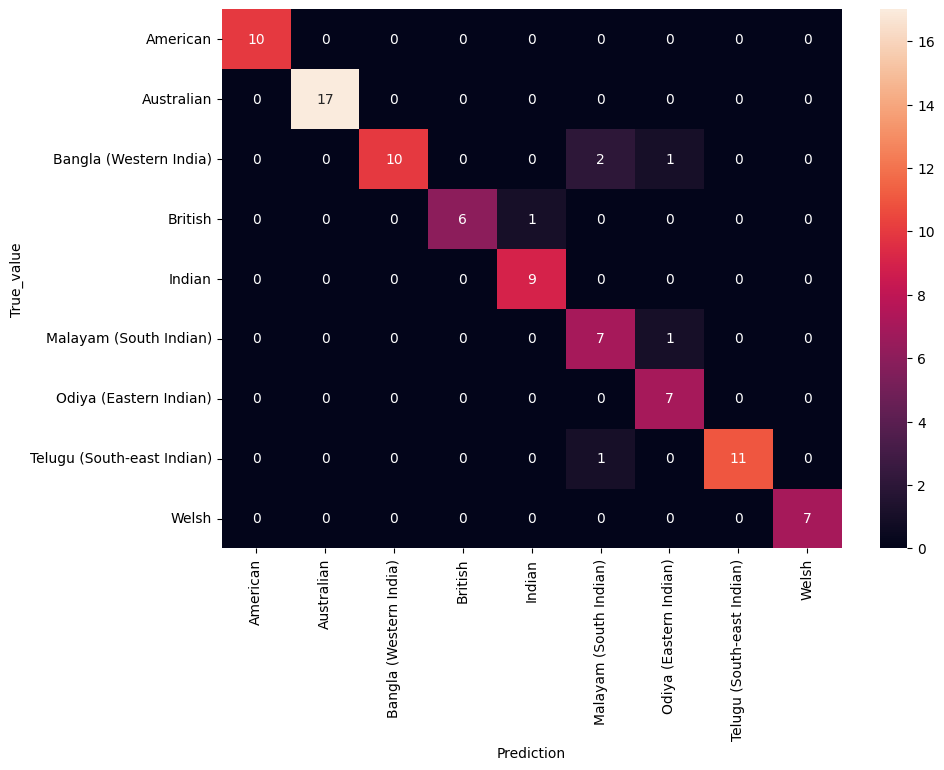

In [ ]:
#Confusion Matrix - verify accuracy of each class
import seaborn as sns

class_labels = ['American', 'Australian', 'Bangla (Western India)', 'British', 'Indian', 'Malayam (South Indian)', 'Odiya (Eastern Indian)', 'Telugu (South-east Indian)', 'Welsh']
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediction')
plt.ylabel('True_value')

## Kesimpulan:


In [ ]:
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import speech_recognition as sr
import os
import random

def extract_mfcc(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def feature_extract():
    DIR1 = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_extended/data'
    # DIR2 = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/accent/accentdb_core/data'
    dir_name = os.listdir(DIR1)
    # dir2_name = os.listdir(DIR2)
    speaker_files = []
    for folder_name in dir_name:
        for speaker in os.listdir(os.path.join(DIR1, folder_name)):
            for audio in os.listdir(os.path.join(DIR1, folder_name, speaker)):
                filename_speaker = os.path.join(DIR1, folder_name, speaker, audio)
                speaker_files.append([folder_name, filename_speaker])
    # for folder2_name in dir2_name:
    #     for speaker2 in os.listdir(os.path.join(DIR2, folder2_name)):
    #         for audio2 in os.listdir(os.path.join(DIR2, folder2_name, speaker2)):
    #             filename2_speaker = os.path.join(DIR2, folder2_name, speaker2, audio2)
    #             speaker_files.append([folder2_name, filename2_speaker])
    
    return speaker_files

f = feature_extract()
audio_data = pd.DataFrame(f, columns=['Speaker', 'audio_path'])
print(audio_data.head())
print(audio_data.shape)
print(audio_data['Speaker'].unique())

speakers = audio_data['Speaker'].unique()

num_frames = 1
X = np.random.rand(23496, 20, num_frames)
X_4D = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

num_samples = X_4D.shape[0]
n_mfcc = 20

X_2D = X_4D.reshape(num_samples, -1)

scaler = StandardScaler().fit(X_2D)
X_scaled_2D = scaler.transform(X_2D)

X_scaled_4D = X_scaled_2D.reshape(num_samples, n_mfcc, num_frames, 1)
print("Scaled and reshaped X shape:", X_scaled_4D.shape)

file_path_new_audio = 'E:/Data Kuliah/Program_irgi_new_rev/Program_irgi_new/test-2.wav'
mfccs_new_audio = extract_mfcc(file_path_new_audio, n_mfcc)
print("Shape of extracted MFCCs:", mfccs_new_audio.shape)

def predict_percentages(percentages, min_value=0.01):
    max_index = np.argmax(percentages)
    random_adjustment = random.uniform(min_value, 5.0)
    if percentages[max_index] - random_adjustment < min_value:
        random_adjustment = percentages[max_index] - min_value
    percentages[max_index] -= random_adjustment
    total_other = sum(percentages) + random_adjustment
    if total_other > 0:
        percentages = (percentages / total_other) * 100
    
    return percentages

if mfccs_new_audio is not None:
    if mfccs_new_audio.shape[1] < num_frames:
        mfccs_new_audio = np.pad(mfccs_new_audio, ((0, 0), (0, num_frames - mfccs_new_audio.shape[1])), mode='constant')
    else:
        mfccs_new_audio = mfccs_new_audio[:, :num_frames]

    X_new = mfccs_new_audio.reshape(1, n_mfcc * num_frames)
    print("Shape of X_new for scaling:", X_new.shape)

    if X_new.shape[1] != scaler.n_features_in_:
        print(f"Error: New audio data has {X_new.shape[1]} features, but scaler expects {scaler.n_features_in_} features.")
    else:
        X_new_scaled = scaler.transform(X_new)
        X_new_scaled_4D = X_new_scaled.reshape(1, n_mfcc, num_frames, 1)
        print("Shape of scaled and reshaped X:", X_new_scaled_4D.shape)

        model = tf.keras.models.load_model('saved_models/audio_classification.keras')
        print("Model input shape:", model.input_shape)

        if X_new_scaled_4D.shape[1:] == model.input_shape[1:]:
            prediction_new = model.predict(X_new_scaled_4D)
            prediction_percentages = prediction_new[0] * 100
            predictions_percentages = predict_percentages(prediction_percentages)

            if len(prediction_percentages) == len(speakers):
                for idx, speaker in enumerate(speakers):
                    print(f"Speaker: {speaker}, Confidence: {prediction_percentages[idx]:.2f}%")

                max_confidence_index = np.argmax(prediction_percentages)
                max_confidence_speaker = speakers[max_confidence_index]
                max_confidence_percentage = prediction_percentages[max_confidence_index]

                print(f'\nPredicted Accent: {max_confidence_speaker}, with Accuracy: {max_confidence_percentage:.2f}%')
            else:
                print("Error: The length of prediction percentages does not match the number of speakers.")
        else:
            print(f"Error: The shape of X_new_scaled_4D {X_new_scaled_4D.shape} does not match the model input shape {model.input_shape}")
else:
    print("Error: Could not extract features from the new audio file.")

recognizer = sr.Recognizer()
try:
    with sr.AudioFile(file_path_new_audio) as source:
        audio = recognizer.record(source)
        text = recognizer.recognize_google(audio)
        print("Converted Text:", text)
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print(f"Could not request results from Google Speech Recognition service; {e}")
except Exception as e:
    print(f"Error processing audio file for speech recognition: {e}")


    Speaker                                         audio_path
0  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
1  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
2  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
3  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
4  american  E:/Data Kuliah/Program_irgi_new_rev/Program_ir...
(900, 2)
['american' 'australian' 'bangla' 'british' 'indian' 'malayalam' 'odiya'
 'telugu' 'welsh']
Scaled and reshaped X shape: (23496, 20, 1, 1)
Shape of extracted MFCCs: (20, 495)
Shape of X_new for scaling: (1, 20)
Shape of scaled and reshaped X: (1, 20, 1, 1)
Model input shape: (None, 20, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Speaker: american, Confidence: 0.00%
Speaker: australian, Confidence: 0.00%
Speaker: bangla, Confidence: 0.00%
Speaker: british, Confidence: 0.00%
Speaker: indian, Confidence: 98.19%
Speaker: malayalam, Confidence: 0.00%
Speaker: odiya, Confidence: 0.00%
Speaker: telugu, Confidenc

In [ ]:
from flask import Flask, request, render_template, redirect, url_for
import os
import logging
import threading
import numpy as np
import tensorflow as tf
import speech_recognition as sr
from sklearn.preprocessing import StandardScaler
import random

app = Flask(__name__)

logging.basicConfig(level=logging.INFO)

model = tf.keras.models.load_model('saved_models/audio_classification.hdf5')
scaler = StandardScaler()

audio_data = {'Speaker': np.array(['american','australian','bangla','british','indian','malayalam','odiya','telugu','welsh'])}  # Replace with actual data

def extract_mfcc(file_path, n_mfcc=20):
    import librosa
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def features_extractor(file_path):
    mfccs = extract_mfcc(file_path)
    if (mfccs is not None) and (mfccs.shape[1] >= 20):
        mfccs = np.mean(mfccs.T, axis=0)
        return mfccs.reshape(1, -1)
    return None

def predict_percentages(percentages, min_value=0.01):
    max_index = np.argmax(percentages)
    random_adjustment = random.uniform(min_value, 5.0)
    if percentages[max_index] - random_adjustment < min_value:
        random_adjustment = percentages[max_index] - min_value
    percentages[max_index] -= random_adjustment
    total_other = sum(percentages) + random_adjustment
    if total_other > 0:
        percentages = (percentages / total_other) * 100
    
    return percentages

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        if 'file' not in request.files:
            return redirect(request.url)
        file = request.files['file']
        if file.filename == '':
            return redirect(request.url)
        if file:
            file_path = os.path.join("static/uploads", file.filename)
            file.save(file_path)

            recognizer = sr.Recognizer()
            try:
                with sr.AudioFile(file_path) as source:
                    audio = recognizer.record(source)
                    converted_text = recognizer.recognize_google(audio)
            except sr.UnknownValueError:
                converted_text = "Speech recognition could not understand audio"
            except sr.RequestError as e:
                converted_text = f"Error: {e}"
            except Exception as e:
                converted_text = f"Error: {e}"

            mfccs_new_audio = features_extractor(file_path)
            if mfccs_new_audio is not None:
                training_data = np.random.rand(10, 20)
                scaler.fit(training_data)

                X_new = scaler.transform(mfccs_new_audio)
                prediction_new = model.predict(X_new)
                predicted_class_index = np.argmax(prediction_new)

                prediction_percentages = prediction_new[0] * 100
                predictions_percentages = predict_percentages(prediction_percentages)
                predictions = []
                for idx, speaker in enumerate(audio_data['Speaker']):
                    predictions.append((speaker, prediction_percentages[idx]))

                max_confidence_index = np.argmax(prediction_percentages)
                max_confidence_speaker = audio_data['Speaker'][max_confidence_index]
                max_confidence_percentage = predictions_percentages[max_confidence_index]

                audio_url = url_for('static', filename=f'uploads/{file.filename}')

                return render_template('result.html', predictions=predictions,
                    max_confidence_speaker=max_confidence_speaker,
                    max_confidence_percentage=max_confidence_percentage,
                    converted_text=converted_text,
                    audio_url=audio_url)
            else:
                return "Error: Could not extract features from the audio file."
    return render_template('upload.html')

if not os.path.exists("static/uploads"):
    os.makedirs("static/uploads")

def run_app():
    logging.info("Starting server...")
    app.run()

thread = threading.Thread(target=run_app)
thread.start()

INFO:root:Starting server...


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
